In [1]:
import numpy as np;
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
import csv
import pandas as pd
import sklearn as sk
from sklearn.model_selection import KFold 
import math
#import pydot
#import graphviz
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})

import statistics as stc

In [10]:
tf.__version__

'2.2.0'

# Trainset and Testset and Validation set

In [281]:
np.random.seed(1001)
data = pd.read_csv('NMC_numerical.csv')

def data_split (data, test_ratio):
    np.random.seed(1001)
    df = pd.DataFrame(data)
    total_row = df.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row -test_row
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df.iloc[train_indx,:], df.iloc[test_idx,:]
    X_test = test.iloc[:,0:20]
    y_test = test.iloc [:,21]
    X_train = train.iloc[:,0:20]
    y_train = train.iloc [:,21]
    return train,X_train,y_train,X_test,y_test
    
train,X_train,y_train,X_test,y_test = data_split(data,0.2)


# 10-fold cross validation
kf = KFold(n_splits=5,random_state =1001,shuffle= True)


# Construct your Neural Network

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras import losses


def Deep_neural(lr, hidden_dimension, hidden_layers, reg=0):

    initializer = tf.keras.initializers.VarianceScaling(scale=2)

    # Reguarizer allows to put penalities on layer parameters or layer activity
    # this can be done for Kenral, bias and activity, the below is for kernal one
    # and this can be specified further depending on your need
    regularizer = tf.keras.regularizers.l2(reg)

    model = Sequential()
    model.add(Dense(hidden_dimension, activation='relu', kernel_initializer=initializer,
                           kernel_regularizer=regularizer, input_dim=20))
    for i in range(hidden_layers):

            model.add(Dense(hidden_dimension, activation='relu', kernel_initializer=initializer,
                           kernel_regularizer=regularizer))
    
    model.add(Dense(1,activation ='linear',kernel_initializer=initializer,
                           kernel_regularizer =regularizer))

    
    model.compile(metrics='mse',optimizer = optimizers.Adam(learning_rate =lr),loss=losses.MeanAbsolutePercentageError())
    return model

# Hyperparameter Tuning

In [6]:
learning_rate = [0.001,0.01, 0.1]
hidden_dim = np.arange(5,21,1).tolist()
hidden_l = np.arange(5,21,1).tolist()

Results_name = ["learning_rate", "hidden_dimension", "hidden_layeres", "RMSE"]
Results =[]



for i in learning_rate:
    for d in hidden_dim:
        for l in hidden_l:
            for train_index, test_index in kf.split(X_train):
                #print("Train:", train_index, "Validation:", test_index)
                X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
                y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
                initial_model = Deep_neural(
                lr=i, hidden_dimension=d, hidden_layers=l)
                history = initial_model.fit(
                x=X_training, y=y_training, batch_size=15, epochs=1)
                A=initial_model.evaluate(x=X_validate, y=y_validate)[1]
                rmse = math.sqrt(A)
                Results.append([i, d, l, rmse])

Results_file = pd.DataFrame(Results, columns =Results_name)
Results_file.to_csv(r'hyperparameter.csv',index=False, header =True)

1/1 [==============================] - 0s 1ms/step - loss: 99.9890 - mse: 31654.3945


In [23]:
Results_file = pd.DataFrame(Results, columns =Results_name)

In [26]:
Results_file.to_csv(r'hyperparameter_optimisation_results.csv',index=False, header =True)

# Save the history in dict format using pickle (Loss against epochs)

In [41]:
import pickle
pickle.dump( history.history, open( "history_1000_IC.p", "a" ) )
#history = pickle.load(open('/trainHistoryDict'), "rb")

TypeError: write() argument must be str, not bytes

In [43]:
with open ('file','w') as f:
    ab= csv.writer(f,quoting =csv.QUOTE_ALL)
    ab.writerow(Results)

In [19]:
import pickle 

with open ('outfile','wb') as fp:
    pickle.dump(Results,fp)

In [20]:
with open ('outfile','wb') as a:
    item =pickle.load(a)

UnsupportedOperation: read

# Plot the history

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
def epoch_history(a): 
    plt.plot(a.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('history_1000.png')
    plt.show()
    
    #When you close the image displayed by plt.show(), 
    #the image is closed and freed from memory.
    #You should call savefig and savetxt before calling show.
    
plot_1= epoch_history(history)


#  Testing

# Train-errors

In [347]:
Experimental =[]
Predicted =[]
#RMSE_train=[]
for train_index, test_index in kf.split(X_train):
                #print("Train:", train_index, "Validation:", test_index)
                X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
                y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
                
                initial_model = Deep_neural(
                lr=0.001, hidden_dimension=20, hidden_layers=8)
                np.random.seed(1001)
                history = initial_model.fit(x=X_training, y=y_training, batch_size=10, epochs=1000,verbose=0)
                np.random.seed(1001)
                y_predict = initial_model.predict(X_validate)
                #RMSE_train = math.sqrt(np.average((y_predict-y_validate)**2))
                Experimental.append([y_validate])
                Predicted.append(y_predict)
                #RMSE_train.append(RMSE_train)


In [348]:
Predicted_train_value =[]

for i in Predicted:
    for b in i:
        for c in b:
            Predicted_train_value.append(c)



In [349]:
Predicted_train_values = pd.DataFrame(Predicted_train_value)
Experimental_train_values = pd.DataFrame(Experimental)

In [350]:
Experimental_train_value =[]

for i in range(Experimental_train_values.shape[0]):
    Ex=Experimental_train_values.iloc[i,0].to_string(index=False)
    Ex_num = Ex.split("\n ")
    a = np.array([float(i) for i in Ex_num])
    Experimental_train_value.extend(a)

In [351]:
Experimental_train_value =pd.DataFrame(Experimental_train_value)
Experimental_train_value

results =pd.concat([Experimental_train_value,Predicted_train_values],axis=1, sort=False)

In [370]:
results.to_csv('EC-ANN-TRAIN-PREDICTED.csv')

In [352]:
RMSE_train = math.sqrt(np.average((results.iloc[:,0]-results.iloc[:,1])**2))

In [353]:
RMSE_train

36.59755270815279

Results_file.to_csv('IC-NMC-PRE-OBS-TRAIN.csv',index=False, header =True)

In [354]:


"""verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar like this:

progres_bar

verbose=2 will just mention the number of epoch like"""
np.random.seed(1001)
optimal_history = initial_model.fit(x=X_train,y=y_train,batch_size=10, epochs=1000,verbose =0)
np.random.seed(1001)
prediction_y = initial_model.predict(x= X_test)
prediction_y = np.ravel(prediction_y)
y_test = np.array(y_test)


In [355]:
Pre_y_test = pd.DataFrame(prediction_y,index=None)
Ex_y_test =pd.DataFrame(y_test)
Ex_y_test.reset_index(drop=True, inplace=True)
results_test =pd.concat([Ex_y_test,Pre_y_test],axis=1,join='inner')

In [371]:
results_test.to_csv('EC_ANN_TEST_PREDICT.csv')

In [356]:

RMSE = math.sqrt(np.average((prediction_y-y_test)**2))
SS_res = sum((prediction_y-y_test)**2)
SS_tot = sum((y_test-stc.mean(y_test))**2)
SS_reg = sum((prediction_y-np.average(y_test))**2)


In [357]:
1-(SS_res/SS_tot)

0.13396352430017866

In [358]:
R_sq = 1-(SS_res/SS_tot)
R_sq
RMSE

26.100059108233523

In [346]:
print(SS_res)
print(SS_tot)
print(SS_reg)

18803.208563741802
26743.960047058823
23421.73012727499


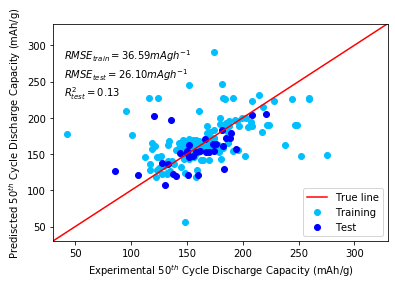

In [369]:
import numpy
import matplotlib.axes as ax
import matplotlib.pyplot as plt

x= y_test
y=prediction_y 

plt.axis([30,330,30,330])
plt.scatter(y=results.iloc[:,1],x=results.iloc[:,0],c='deepskyblue',label='Training')
plt.scatter(x,y, c='blue',label='Test')
plt.plot([30,330],[30,330],label ='True line',c='red')
plt.legend(loc='lower right')
#plt.title(label='SVM-EC-Results-Plot')

plt.xlabel(r'Experimental $50^{th}$ Cycle Discharge Capacity (mAh/g)')
plt.ylabel(r'Prediscted $50^{th}$ Cycle Discharge Capacity (mAh/g)')
plt.text(40,230,r'$RMSE_{train}=36.59 mAgh^{-1}$'+'\n'+r'$RMSE_{test}=26.10 mAgh^{-1}$' +"\n"+ '$R^2_{test}=0.13$')

plt.savefig('ANN-EC-Predicted-vs-test.png',dpi=600)
plt.show()



# Save the model (last step) 

In [372]:
initial_model.save('/Users/mike/Dropbox/Mike Wang/Doped_NMC/ANN/EC')

INFO:tensorflow:Assets written to: /Users/mike/Dropbox/Mike Wang/Doped_NMC/ANN/EC/assets
